<a href="https://colab.research.google.com/github/caiocmello/netzdg/blob/main/Topic_modelling_NetzDG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [ ]:
# Installation

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
!pip install pyLDAvis
!python -m spacy download de_core_news_sm
print('Installation completed')

--2024-07-18 13:58:10--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2024-07-18 13:58:10--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  29.3MB/s    in 0.5s    

2024-07-18 13:58:10 (29.3 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

### Import packages and load dataset

In [ ]:
# Import packages and load dataset (use 'df_netzdg_blue&purple.csv')

import pandas as pd
import nltk
import spacy
import plotly.express as px
import plotly.graph_objects as go
import re
import os
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim as gensimvis
warnings.filterwarnings("ignore", category=DeprecationWarning)
from spacy.lang.en.stop_words import STOP_WORDS as en_stopwords
from spacy.lang.de.stop_words import STOP_WORDS as de_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
df = pd.read_csv('df_netzdg_blue&purple.csv')
mallet_path = '/content/mallet-2.0.8/bin/mallet'

### Create data

In [ ]:
# Run cell to create data (Steps performed: Tokenization, Lemmatization, Ngrams implementation, Speech of tag selection)

data = list(df.text)

bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

# get stopwords from spacy library
stopwords_de = list(de_stopwords)
stopwords_en = list(en_stopwords)
stopwords = stopwords_de + stopwords_en #create a mixed list of stopwords (German and English)
# Edit your list of stopwords manually
add_to_stopwords = ['rt', 'https']
stop_words = stopwords + add_to_stopwords


def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""

    # remove stopwords, short tokens and letter accents
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]

    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]

    texts_out = []

    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])

    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]

    return texts_out

data_ready = process_words(data)

### Create dictionary and corpus

In [ ]:
# Check number of words in data
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 7695


In [ ]:
# See most frequent words in corpus
corpus = [id2word.doc2bow(text) for text in data_ready]
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])
dict_df.sort_values('freq', ascending=False).head(10)

,freq
netzdg,2113
facebook,279
gesetz,252
zensur,236
fur,207
uber,178
twitter,144
bundestag,141
hwieduwilen,104
inhalt,102


In [ ]:
# Cleaning: filtering out words with frequency higher than 280.
extension = dict_df[dict_df.freq>280].index.tolist()
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 7636


In [ ]:
# Filter out words that occur less than 10 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 423


In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### Training model


In [ ]:
# Train LDA model and see topics in table (Number of topics = 10)
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
#id2word = id2word.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

tm_results = model[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=20)] for n in range(0, model.num_topics)]
pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, model.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"loschen, staat, strafbar, nennen, zensurgesetz, schnell, uber, leben, offenbar, beleidigung, justiz, lesen, inhalt, geben, hetze, stark, netz, gelten, hwieduwilen, text"
Topic2,"netz, herr, hass, fordern, regierung, naturlich, kampf, fall, bundesrat, kommentar, bringen, woche, beschwerde, alice_weidel, politisch, medium, debatte, sozial, twitter, schaffen"
Topic3,"zensur, internet, kritisieren, fallen, bundestag, thema, heiko, twitter, arnd_haller, afdimbundestag, etc, sperrung, drdavidberg, anhorung, land, beginnen, toll, sache, finden, zensieren"
Topic4,"kritik, bundesregierung, staatstrojan, freiheit, nehmen, afdimbundestag, minister, ware, verscharfung, bundestag, opposition, fraktion, heikomaas, stimmen, leute, deutsch, grundrecht, wert, uberwachung, groko"
Topic5,"halt, sprechen, problem, treten, losch, gesetz, dienst, bmjv_bund, kraft, netzpolitik, liegen, treffen, kommission, fest, verscharft, diskussion, koln, gutachten, fakenews, durfen"
Topic6,"facebook, uber, twitter, mal, frage, gesetz, burg, sas_assion, sperren, deutlich, aktuell, wichtig, sozial, konn, inhalt, freiheit, funktionieren, bußgeld, zahlen, kippen"
Topic7,"maas, demokratie, sperren, inhalt, genau, warnen, bitte, rechtswidrig, sogar, hate, afdwahlen, gefahr, zensur, eigentlich, loschen, beitrag, bleiben, beitrage, eskensaskia, loschung"
Topic8,"afd, bundestag, stehen, lassen, weg, linker, gesetz, stellen, abschaffen, steinhoefel, beschließen, letzter, mal, freiheit, afdimbundestag, nutzer, zahlreich, anderung, gerne, frei"
Topic9,"fur, gesetz, deutsch, frei, hwieduwilen, brauchen, uber, justizminister, einfach, wissen, neu, zeigen, meinung, abschaffung, welt, reform, digital, politiker, internet, gericht"
Topic10,"klar, partei, afdimbundestag, finden, sehen, wort, schreiben, entwurf, pirat, privat, kontrolle, aufhebung, bedeuten, gesetzesentwurf, gesetzentwurf, fuhrt, nachste, stellungnahme, rechtsstaat, artikel"


In [ ]:
# Check coherence score

# Assuming 'id2word' is a standard Python dictionary, convert it to a gensim Dictionary
id2word_gensim = Dictionary.from_corpus(corpus, id2word=id2word)
coherence_model_lda = CoherenceModel(model=model, texts=data_ready, dictionary=id2word_gensim, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nCoherence Score:  0.4687904958671589


### Topics visualisation

In [ ]:
# Visualise topics

vis_data = gensimvis.prepare(model, corpus, id2word_gensim, sort_topics=False)
pyLDAvis.display(vis_data)

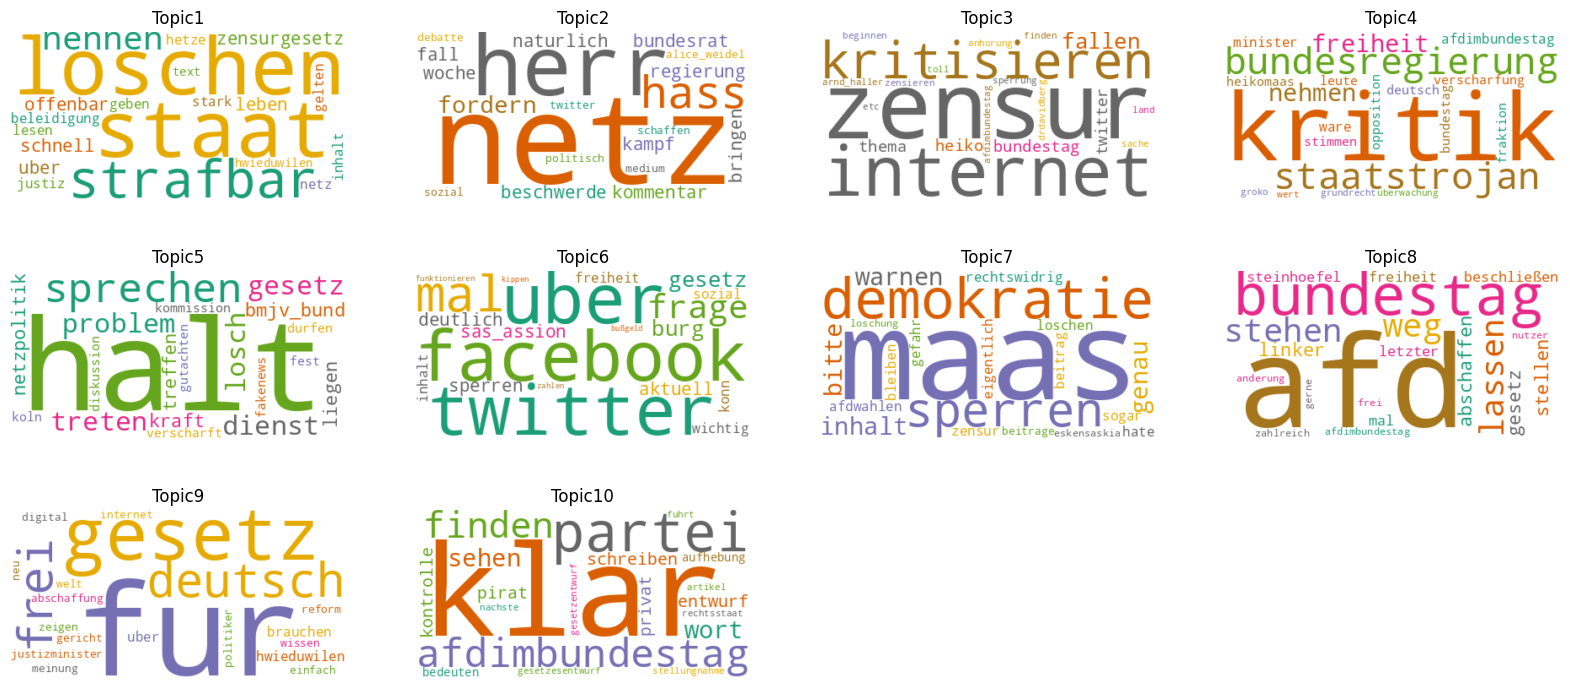

In [ ]:
# Visualise Wordclouds (topics)

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])

    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

## References

*  [Topic Modeling — LDA Mallet Implementation in Python — Part 1](https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2)
*  [Topic Modeling — LDA Mallet Implementation in Python — Part 2](https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396)
*  [Gensim LDA Model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py)
*  [pyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know)
*  [Getting Started with Topic Modeling and MALLET](https://programminghistorian.org/en/lessons/topic-modeling-and-mallet)
*  [Topic modeling made just simple enough](https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/)
*  [The Myth of Text Analytics and Unobtrusive Measurement](https://www.scottbot.net/HIAL/index.html@p=16713.html)
*  [Topic Modeling for Humanists: A Guided Tour](https://web.archive.org/web/20160713181540/http://www.scottbot.net/HIAL/index.html@p=19113.html)
*  [SOME ASSEMBLY REQUIRED: UNDERSTANDING AND INTERPRETING TOPICS IN LDA MODELS OF FIGURATIVE LANGUAGE](https://web.archive.org/web/20160704150726/http://www.lisarhody.com:80/some-assembly-required/)

---

## Important information

#### How to read the visualisation:

*   Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
*   Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
*  Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.

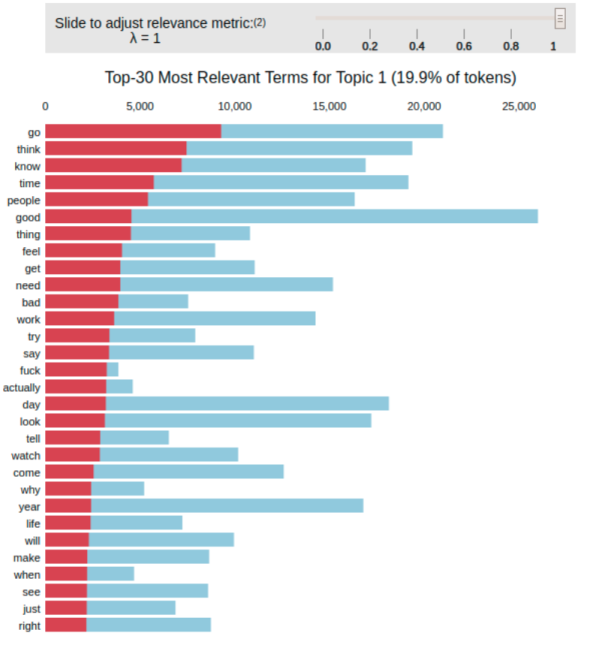

*  The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 1 and 2. They seem to be both about social life, but it is much easier to tell the difference between topics 1 and 3. We can tell that topic 3 is about politics.

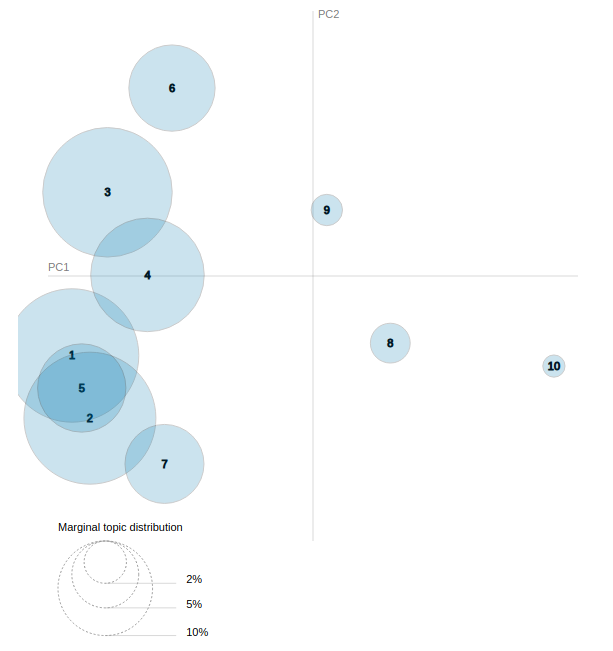

*   A good topic model will have big and non-overlapping bubbles scattered throughout the chart. As we can see from the graph, the bubbles are clustered within one place.

Source: https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know
